# Data prep

In [ ]:
import pandas as pd 
rway_img_df  = pd.read_csv("collection_images_download.csv")
# EXTRACT BRAND FROM IMAGE NAME
rway_img_df['brand'] = rway_img_df['image_name'].str.lower()
rway_img_df['brand'] = rway_img_df['brand'].str.split('couture').str[0]
rway_img_df['brand'] = rway_img_df['brand'].str.split('ready-to-wear').str[0]
rway_img_df['brand'] = rway_img_df['brand'].str.split('menswear').str[0]
rway_img_df['brand'] = rway_img_df['brand'].str.replace("-", " ")
rway_img_df['brand'] = rway_img_df['brand'].str.strip()

#brand_keywords = ['rick owens', 'louis vuitton', 'versace', 'giorgio armani', 'hermes', 'dries van noten', 'chanel']
brand_keywords = ['rick owens', 'dries van noten','versace', 'louis vuitton','chanel','giorgio armani']

data_df = rway_img_df[rway_img_df['brand'].isin(brand_keywords)]

# rename brand in target column
data_df['target'] = data_df['brand']
# factorized 'brand' using pandas
data_df['target'] = pd.factorize(data_df['target'])[0]


In [ ]:
data_df['image_path_no_bkgnd'] = data_df['image_path'].astype(str)
for index, row in data_df.iterrows():
    # Split the image path into base name and extension
    base_name, extension = row['image_path_no_bkgnd'].split('.')

    # Add "-no-bkgnd" to the base name
    new_base_name = f"{base_name}-no-bkgnd"

    # Concatenate the new base name with the extension
    new_image_path = f"{new_base_name}.{extension}"

    data_df.at[index, 'image_path_no_bkgnd'] = new_image_path


In [ ]:
# factorized 'brand' using pandas
data_df['target'] = pd.factorize(data_df['target'])[0]

# VGG16 with self-attention - img with no bkg

In [4]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Attention

# My  simple_vgg16_attention 
def simple_vgg16_attention(input_shape=(224, 224, 3), num_classes=10):
    input_layer = Input(shape=input_shape)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
    x = MaxPooling2D((2, 2))(x)
    
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    att_x = Attention()([x, x])  # Add Self-Attention layer here
    x = MaxPooling2D((2, 2))(att_x)
    
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    
    x = Dense(256, activation='relu')(x)
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    output_layer = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=input_layer, outputs=output_layer)
    return model
print('model defined')
   
# Load the image data and labels

# Split the data into training and validation sets
X_train_paths, X_val_paths, y_train, y_val = train_test_split(
    data_df['image_path_no_bkgnd'],
    data_df['target'],
    test_size=0.2,
    random_state=1234
)

# Define image dimensions (img_height and img_width) to resize the images during preprocessing.
img_height, img_width = 224, 224

# Map the brand labels in y_train and y_val to their corresponding integer labels using the brand_to_label dictionary.
brand_to_label = {brand: i for i, brand in enumerate(np.unique(data_df['target']))}

# Calculate the number of classes (num_classes) based on the unique labels.
num_classes = len(brand_to_label)

# Define the preprocess_image function to load, resize, and normalize the pixel values of the images.
def preprocess_image(image_path):
    image_path = './imgs/images/images/' + image_path  # Add the path prefix
    image = load_img(image_path, target_size=(img_height, img_width))
    image = img_to_array(image)
    image = image / 255.0  # Normalize
    return image

print('preprocess imge function defined' )
print('preprocess imge function initialized' )

# Preprocess the images in X_train and X_val by applying the preprocess_image function to each image path.
X_train = np.array([preprocess_image(path) for path in X_train_paths])
X_val = np.array([preprocess_image(path) for path in X_val_paths])

print('preprocess imge function completed' )



model define
preprocess imge function defined
preprocess imge function initialized
preprocess imge function completed


In [5]:

#Convert the integer labels in y_train and y_val to one-hot encoded vectors
y_train = tf.keras.utils.to_categorical(y_train, num_classes=num_classes)
y_val = tf.keras.utils.to_categorical(y_val, num_classes=num_classes)

#  Create the custom simple_vgg16 model
input_shape = (img_height, img_width, 3)
model = simple_vgg16_attention(input_shape=input_shape, num_classes=num_classes)

#Compile the model with an appropriate optimizer and loss function (e.g., 'adam' optimizer and 'categorical_crossentropy' loss)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print('model initialized')

#Train the model using the preprocessed data
history_100_new3 = model.fit(X_train, y_train, batch_size=32, epochs=200, validation_data=(X_val, y_val))


2023-08-24 21:14:18.036989: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2023-08-24 21:14:18.037029: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2023-08-24 21:14:18.037038: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2023-08-24 21:14:18.037213: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-08-24 21:14:18.037228: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


model initialized
Epoch 1/200


2023-08-24 21:14:23.321886: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


129/129 [==============================] - ETA: 0s - loss: 1.7920 - accuracy: 0.1738

2023-08-24 21:14:40.950433: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


129/129 [==============================] - 20s 144ms/step - loss: 1.7920 - accuracy: 0.1738 - val_loss: 1.7930 - val_accuracy: 0.1558
Epoch 2/200
129/129 [==============================] - 19s 147ms/step - loss: 1.7931 - accuracy: 0.1714 - val_loss: 1.7918 - val_accuracy: 0.1753
Epoch 3/200
129/129 [==============================] - 19s 148ms/step - loss: 1.7913 - accuracy: 0.1689 - val_loss: 1.7912 - val_accuracy: 0.1743
Epoch 4/200
129/129 [==============================] - 19s 147ms/step - loss: 1.7855 - accuracy: 0.1833 - val_loss: 1.7547 - val_accuracy: 0.2210
Epoch 5/200
129/129 [==============================] - 19s 147ms/step - loss: 1.7410 - accuracy: 0.2291 - val_loss: 1.6792 - val_accuracy: 0.2697
Epoch 6/200
129/129 [==============================] - 19s 149ms/step - loss: 1.6894 - accuracy: 0.2695 - val_loss: 1.6530 - val_accuracy: 0.2717
Epoch 7/200
129/129 [==============================] - 19s 149ms/step - loss: 1.6740 - accuracy: 0.2795 - val_loss: 1.6251 - val_accurac

In [34]:
# Save the trained model to an HDF5 file
model.save('vgg16_200epoch_no_bkg.h5')

print('vgg16_200epoch_no_bkg.h5')

/Users/elenaabcc/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


vgg16_200epoch_no_bkg.h5


# Model evaluation

### Confusion Matrix


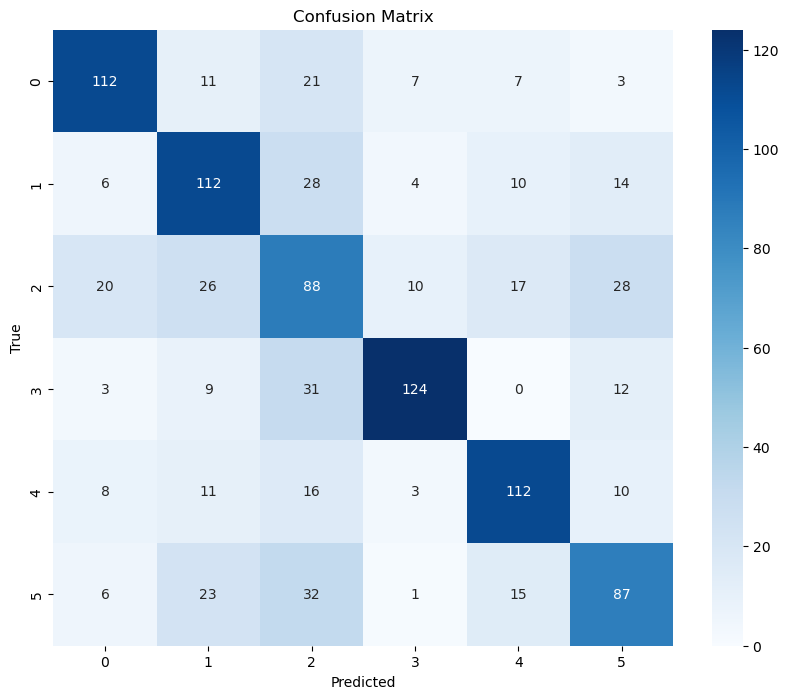

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
confusion_mtx = confusion_matrix(np.argmax(y_val, axis=1), y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues',
            xticklabels=brand_to_label.keys(),
            yticklabels=brand_to_label.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


### Validation and Train Accuracy

In [7]:
import json 
json.dump(history_100_new3.history, open('vgg16_200epoch_no_bkg.json', 'w'))
vgg16_200epoch_no_bkg = pd.read_json('vgg16_200epoch_no_bkg.json')

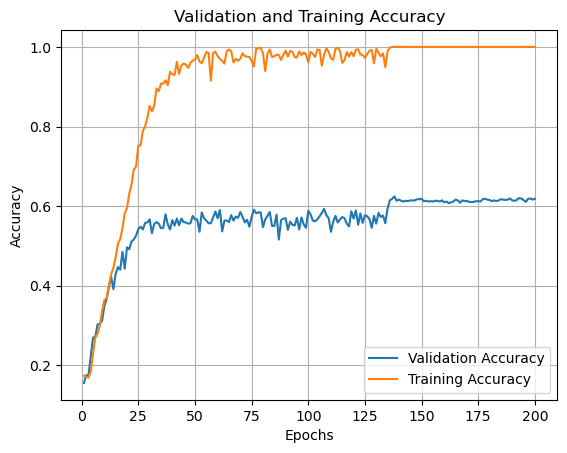

In [8]:
import matplotlib.pyplot as plt
val_accuracy = vgg16_200epoch_no_bkg['val_accuracy']
accuracy = vgg16_200epoch_no_bkg['accuracy']
epochs = range(1, len(val_accuracy) + 1)


plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.plot(epochs, accuracy, label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation and Training Accuracy')
plt.legend()
plt.grid(True)
plt.show()


### Validation and Train Loss

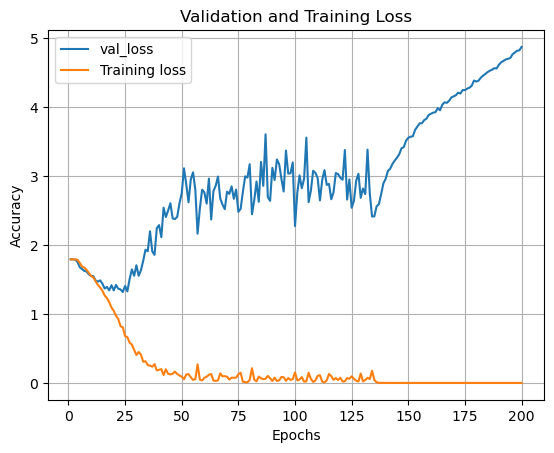

In [9]:
val_accuracy = vgg16_200epoch_no_bkg['val_loss']
accuracy = vgg16_200epoch_no_bkg['loss']
epochs = range(1, len(val_accuracy) + 1)

plt.plot(epochs, val_accuracy, label='val_loss')
plt.plot(epochs, accuracy, label='Training loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation and Training Loss')
plt.legend()
plt.grid(True)
plt.show()


### Accuracy (Accuratezza): 

In [32]:
# Accuratezza durante la validazione
validation_accuracy = history_100_new3.history['val_accuracy']

# Calcola la media dell'accuratezza sulla validazione
average_validation_accuracy = sum(validation_accuracy) / len(validation_accuracy)

print("Avg Val Accuracy after 200 epoch:", average_validation_accuracy)

Avg Accuracy after 100 epoch: 0.5573904557526111


In [33]:
# Accuratezza durante l'addestramento
training_accuracy = history_100_new3.history['accuracy']


# Calcola la media dell'accuratezza sulla validazione
average_training_accuracy = sum(training_accuracy) / len(training_accuracy)

print("Avg Train Accuracy after 100 epoch:", average_training_accuracy)


Avg Train Accuracy after 100 epoch: 0.9072139722108841


### Area Under the Receiver Operating Characteristic Curve (AUC-ROC):

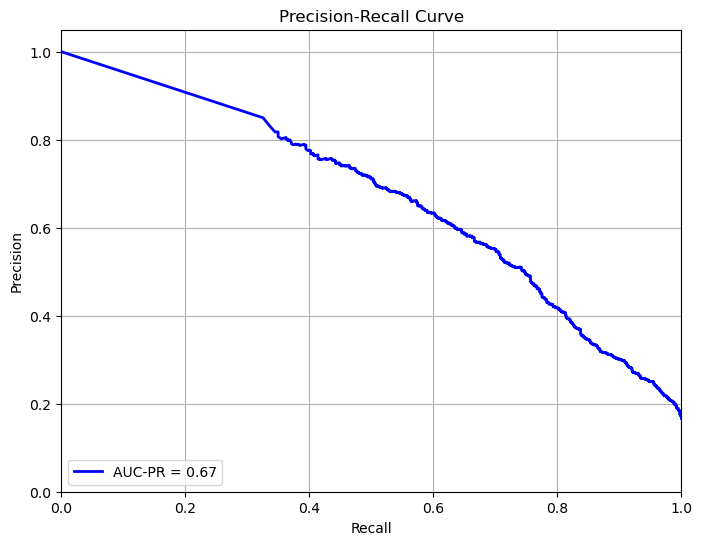

In [15]:
from sklearn.metrics import auc, precision_recall_curve
import matplotlib.pyplot as plt

precision, recall, _ = precision_recall_curve(y_val.ravel(), y_pred.ravel())

#'AUC-PR
auc_pr = auc(recall, precision)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2, label='AUC-PR = %0.2f' % auc_pr)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.grid(True)
plt.show()


2023-08-24 22:28:23.294342: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


33/33 [==============================] - 2s 45ms/step


### Log Loss (Cross-Entropy Loss): 

In [13]:
from tensorflow.keras.losses import categorical_crossentropy

# Calcola la Log Loss sui dati di validazione
loss = categorical_crossentropy(y_val, y_pred)

# Calcola la media della Log Loss su tutti i campioni
average_loss = np.mean(loss)

print("Log Loss:", average_loss)


Log Loss: 3.892851


### F1-Score: 

In [14]:
from sklearn.metrics import f1_score

# Calcola la F1-Score per le previsioni e le etichette reali
f1score = f1_score(np.argmax(y_val, axis=1), y_pred_classes, average='weighted')

print("Weighted F1-Score:", f1score)


Weighted F1-Score: 0.6226680834512366


# Viz Attention

1/1 [==============================] - 0s 130ms/step


2023-08-24 23:31:34.992886: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


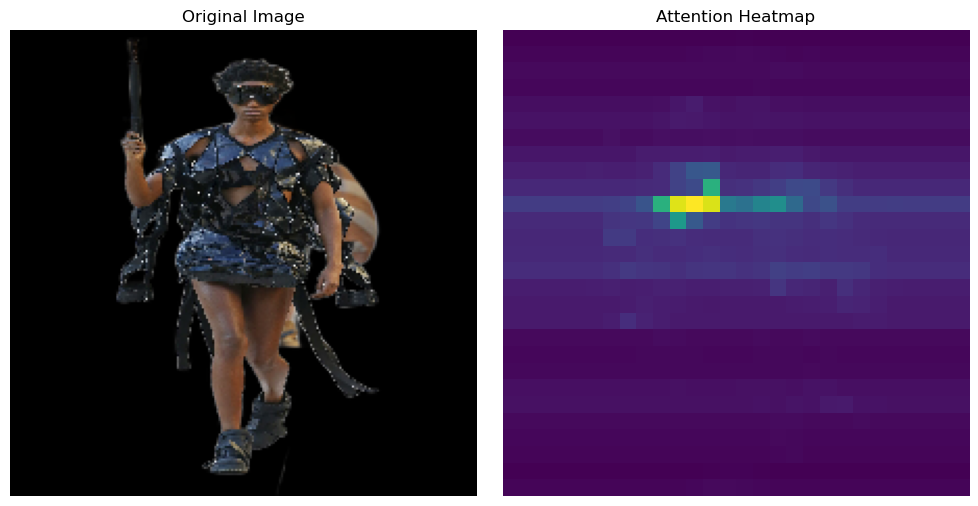

1/1 [==============================] - 0s 99ms/step


2023-08-24 23:31:35.462660: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


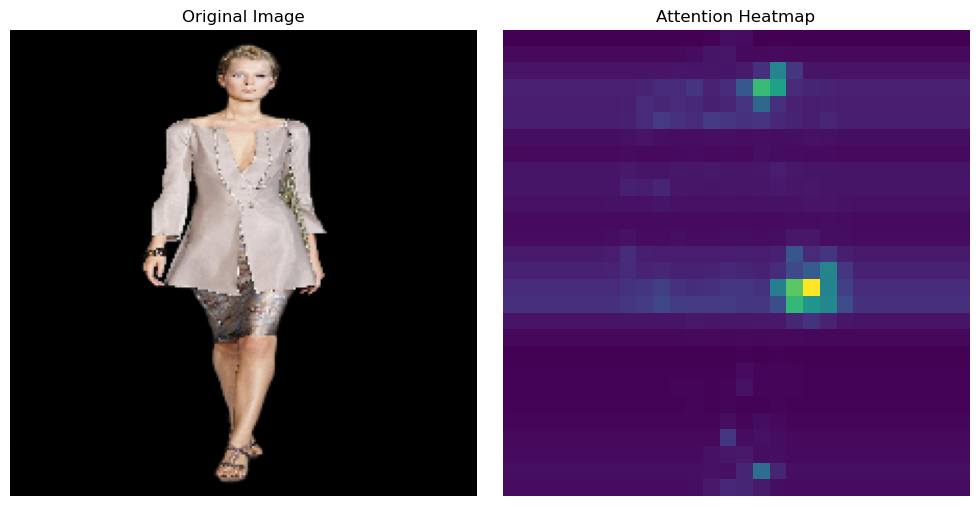

1/1 [==============================] - 0s 74ms/step


2023-08-24 23:31:35.856531: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


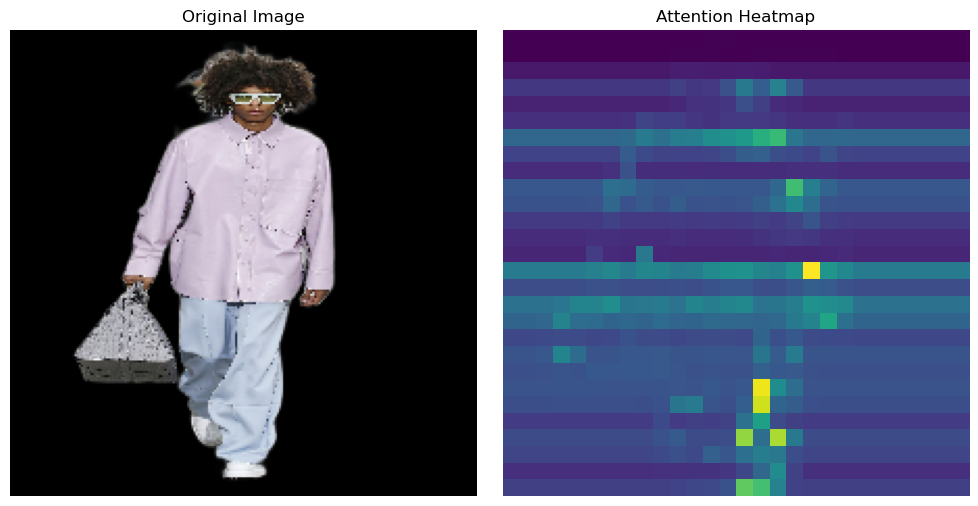

1/1 [==============================] - 0s 79ms/step


2023-08-24 23:31:36.148600: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


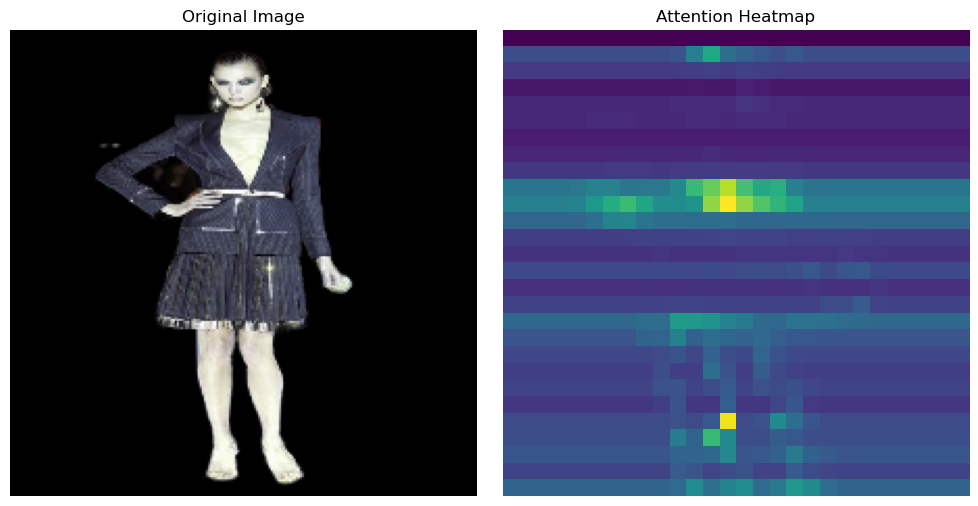

1/1 [==============================] - 0s 93ms/step


2023-08-24 23:31:36.398382: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


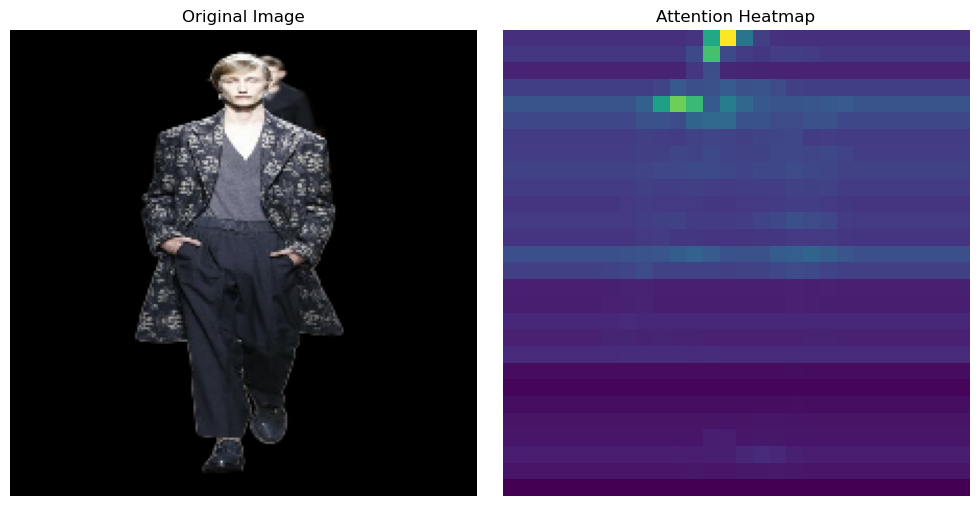

1/1 [==============================] - 0s 79ms/step


2023-08-24 23:31:36.629311: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


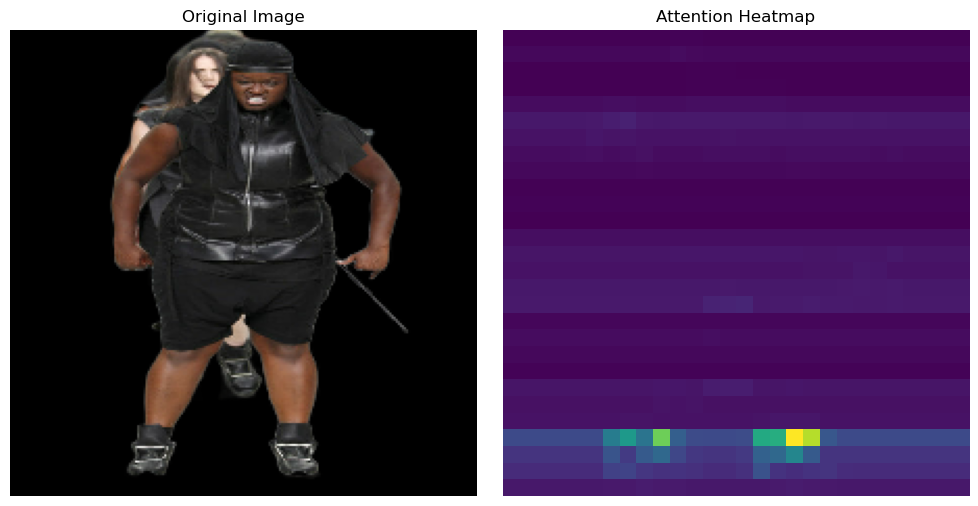

1/1 [==============================] - 0s 78ms/step


2023-08-24 23:31:36.847906: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


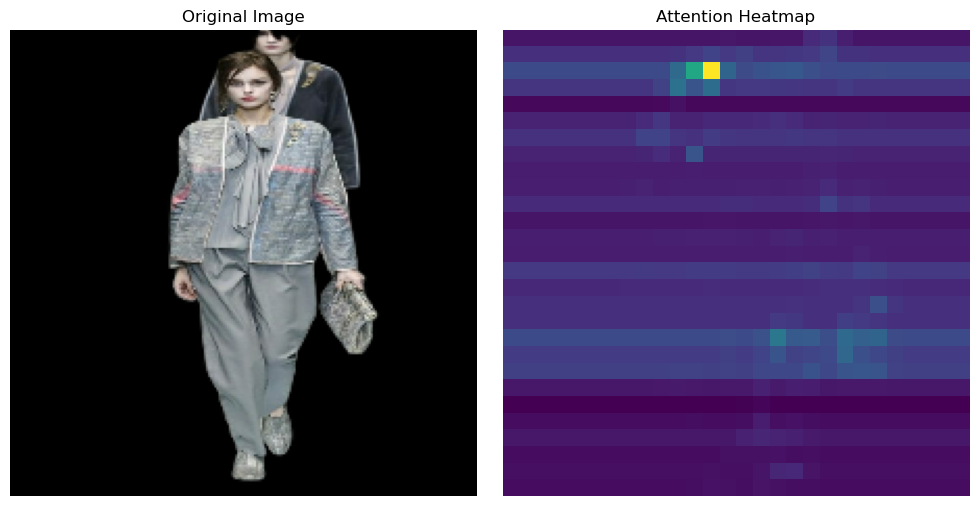

1/1 [==============================] - 0s 83ms/step


2023-08-24 23:31:37.163797: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


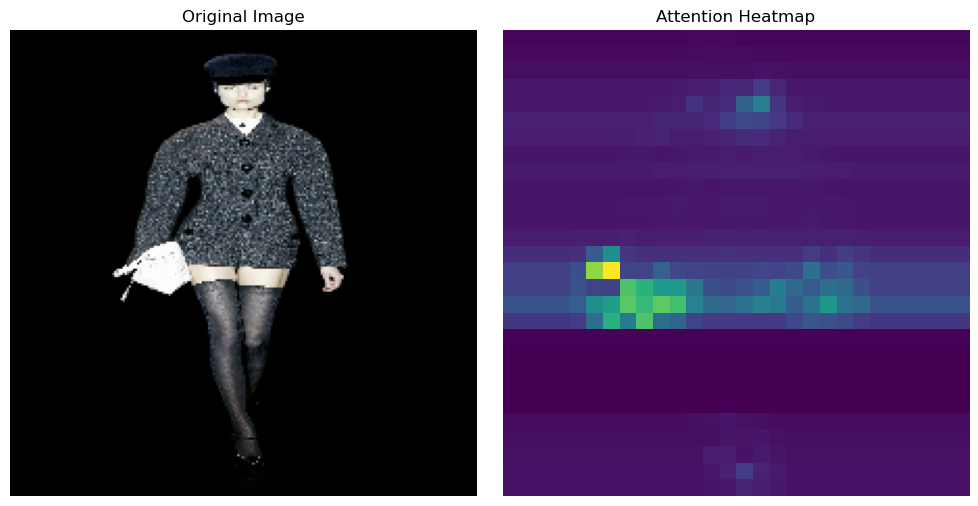

1/1 [==============================] - 0s 127ms/step


2023-08-24 23:31:37.476307: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


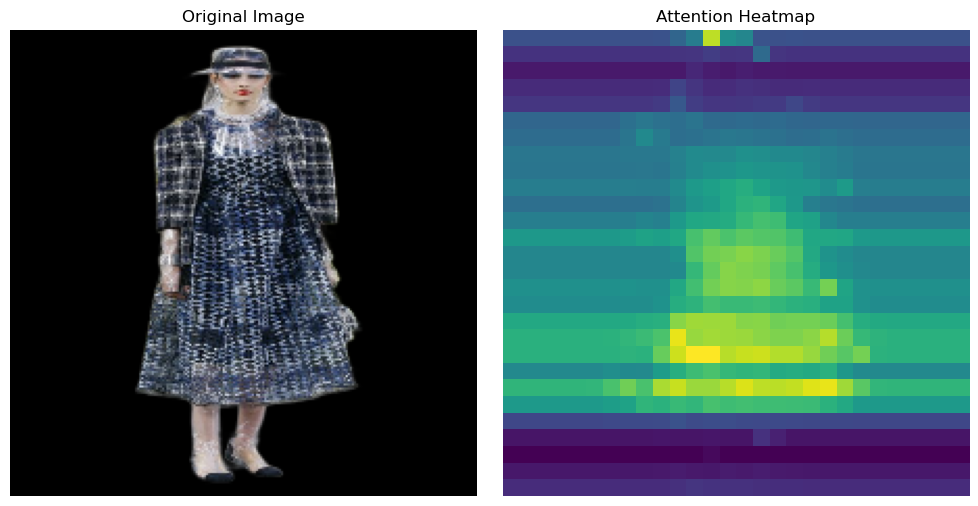

1/1 [==============================] - 0s 77ms/step


2023-08-24 23:31:37.711963: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


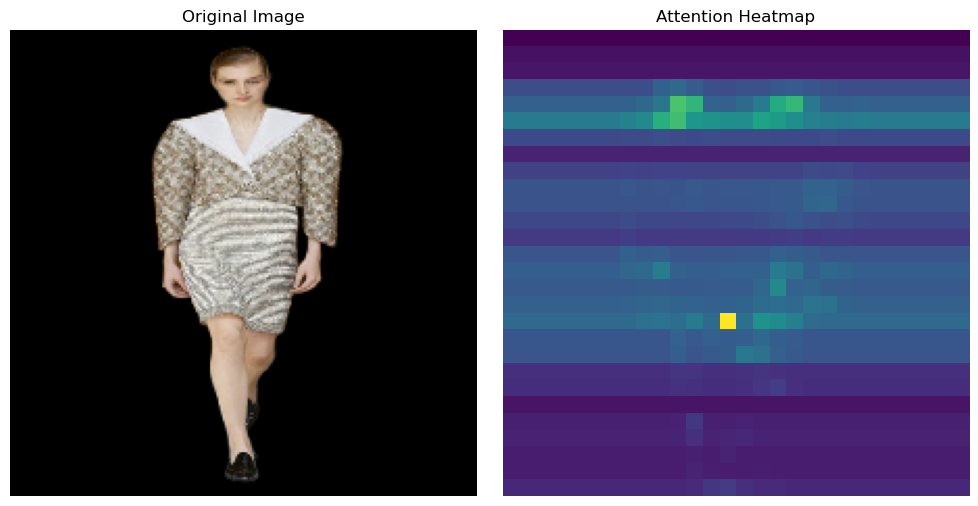

1/1 [==============================] - 0s 82ms/step


2023-08-24 23:31:37.931624: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


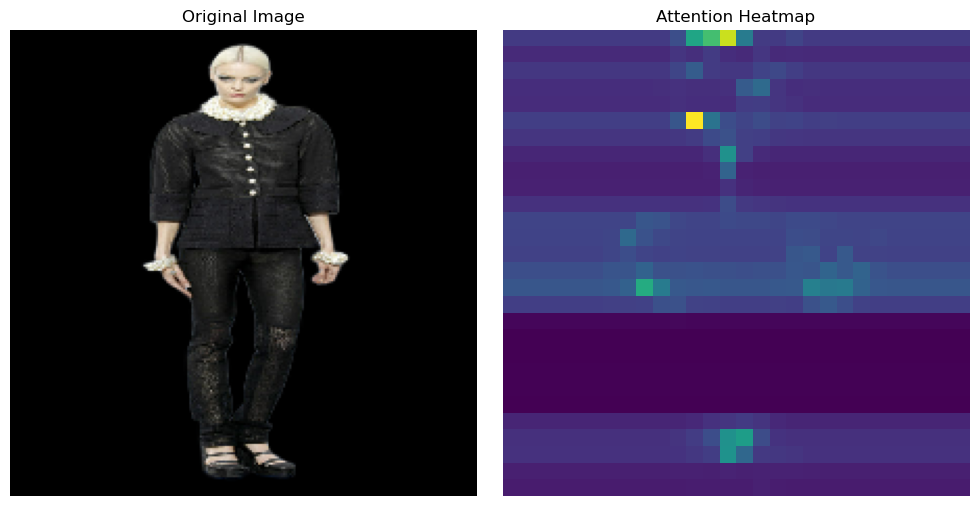

1/1 [==============================] - 0s 70ms/step


2023-08-24 23:31:38.216111: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


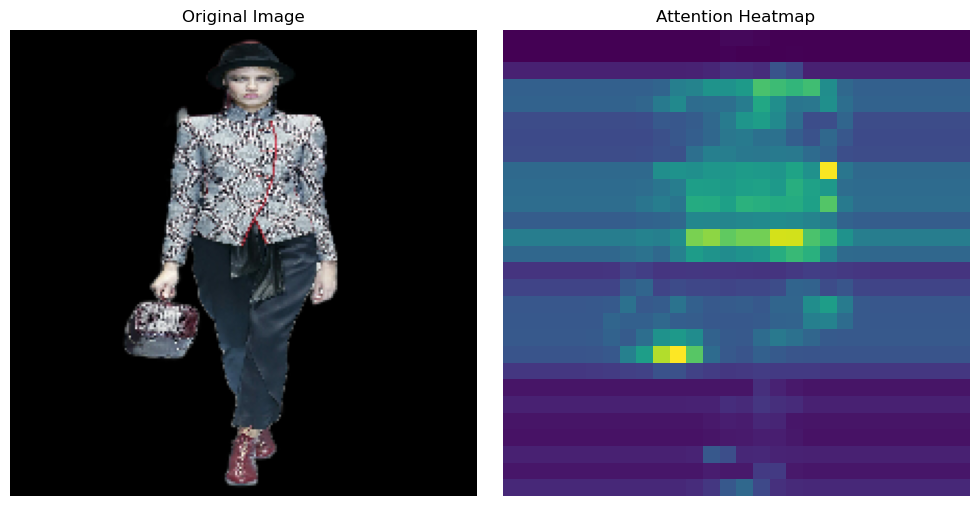

1/1 [==============================] - 0s 70ms/step


2023-08-24 23:31:38.577989: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


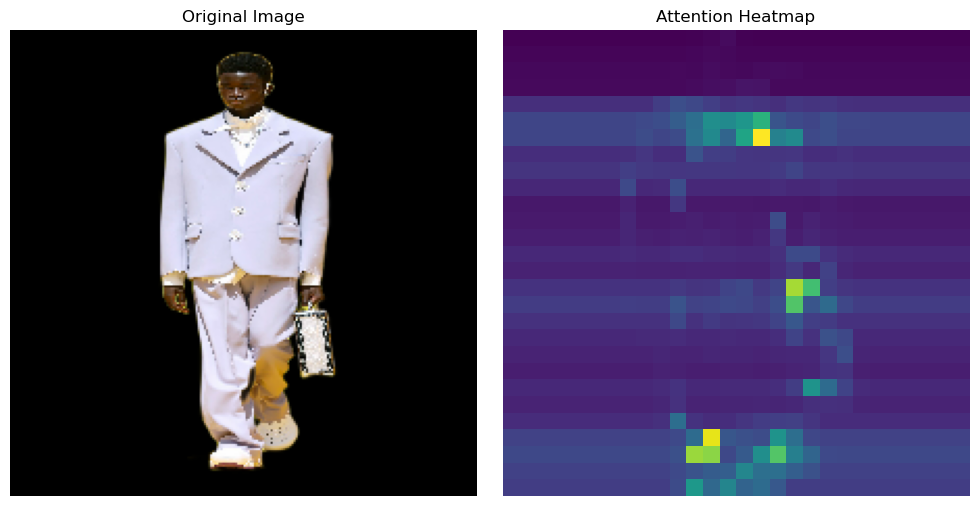

1/1 [==============================] - 0s 56ms/step


2023-08-24 23:31:38.929294: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


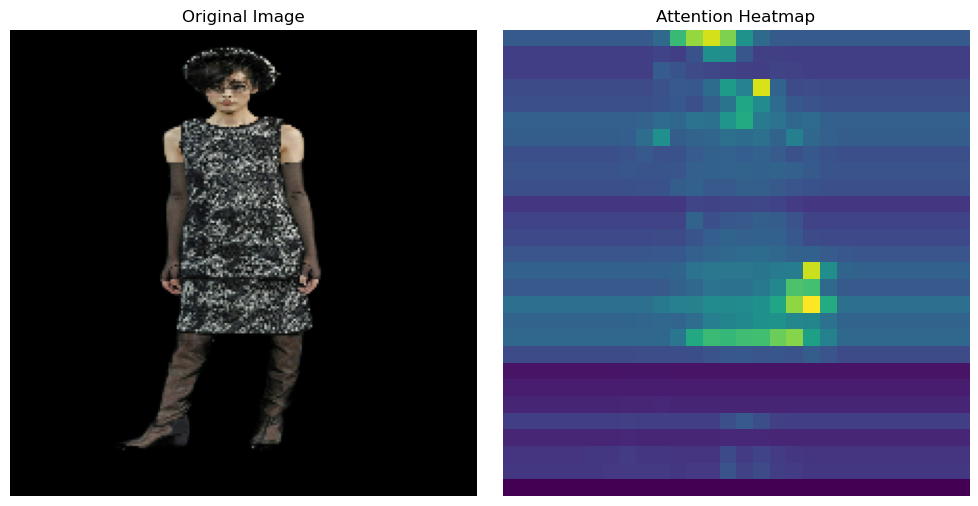

1/1 [==============================] - 0s 62ms/step


2023-08-24 23:31:39.217945: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


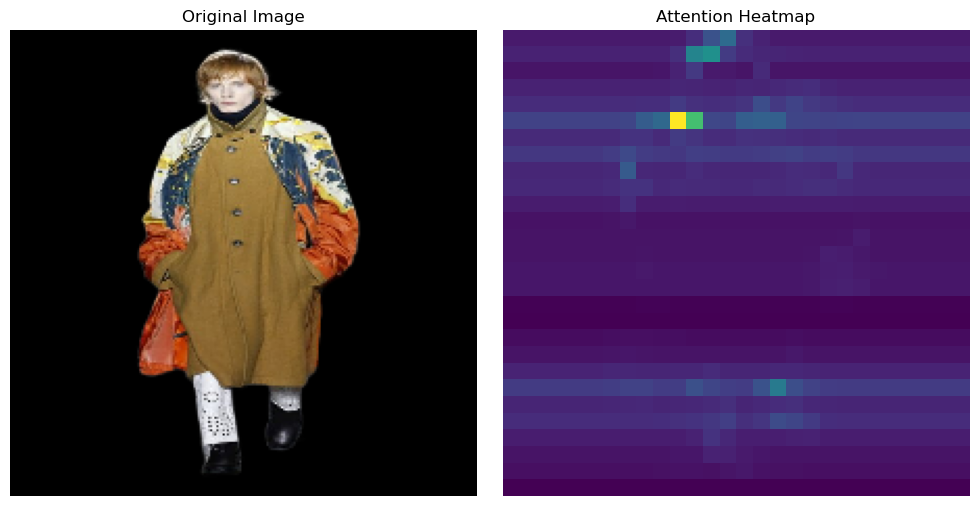

In [38]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Input, Dense, GlobalAveragePooling2D, Flatten, Dropout
from tensorflow.keras.layers import Attention


# Convert X_val_paths to a numpy array
X_val_paths = np.array(X_val_paths)

attention_layer_name = 'attention'

# Define a function to extract attention weights and generate heatmaps
def visualize_attention(model, img_path, layer_name):
    img = preprocess_image(img_path)
    img = np.expand_dims(img, axis=0)
    
    # Create a submodel that outputs attention weights
    submodel = Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
    attention_maps = submodel.predict(img)
    
    # Reshape attention maps for visualization
    attention_maps = np.squeeze(attention_maps)
    
    # Create a heatmap by summing along the channel axis
    heatmap = np.sum(attention_maps, axis=-1)
    
    # Normalize the heatmap
    heatmap /= np.max(heatmap)
    
    return heatmap

# Choose 15 image 
sample_image_indices = [24, 35, 48, 61, 70, 81, 92, 103, 114, 125, 136, 147, 144, 169, 180]
# Define the desired size for the images
img_size = (224, 224)

for idx in sample_image_indices:
    # Get the image path using the chosen index
    sample_image_path = X_val_paths[idx]

    # Generate the attention heatmap for the chosen image and layer
    heatmap = visualize_attention(model, sample_image_path, attention_layer_name)

    # Display the original image and attention heatmap side by side
    plt.figure(figsize=(10, 5))

    # Original Image
    plt.subplot(1, 2, 1)
    original_image = load_img('./imgs/images/images/' + sample_image_path, target_size=img_size)
    plt.imshow(original_image)
    plt.title('Original Image')
    plt.axis('off')

    # Attention Heatmap
    plt.subplot(1, 2, 2)
    plt.imshow(heatmap, cmap='viridis')
    plt.title('Attention Heatmap')
    plt.axis('off')

    plt.tight_layout()
    plt.show()
